In [1]:
import matplotlib as mpl
import numpy as np
import scipy 
import pickle
import pylab as plt
import pandas as pd
import copy
%matplotlib inline

try:
    import cPickle as pickle
except ImportError:
    import pickle
import scipy
from scipy import interpolate
from scipy.interpolate import interp2d, NearestNDInterpolator,LinearNDInterpolator

In [2]:
def WeightAtEachPt(Flux,Tau,NumLaunched,Weight):
    InjectArea=np.pi*100**2 #cm
    Tau_sec=Tau*24*60*60 #take from days to seconds
    W= Flux*Tau_sec*InjectArea*(2*NumLaunched/(4*np.pi*.6))**-1*Weight*2
    return W

In [3]:
def Ry (R, phi, theta):
    return (R) * np.cos(phi)

def Rx (R, phi, theta):
    return (R) * np.sin(phi) * np.cos(theta)

def Rz (R, phi, theta):
    return (R) * np.sin(phi) * np.sin(theta)

In [4]:
f=open("/Users/rogerslc/Documents/MuFluxPred/MCEqFluxMeshes.pkl","rb")
EBins, cosas, gs, FluxMeshes= pickle.load(f)
f.close()

f=open("/Users/rogerslc/Documents/MuFluxPred/MCEqFluxMeshes_Zat.pkl","rb")
EBinsZ, cosasZ, gsZ,FluxMeshesZat= pickle.load(f)
f.close()   

f=open("/Users/rogerslc/Documents/MuFluxPred/MCEqFluxMeshes_Epos.pkl","rb")
EBinsE, cosasE, gsE,FluxMeshesEpos= pickle.load(f)
f.close()   

f=open("/Users/rogerslc/Documents/MuFluxPred/LinInterps.pkl","rb")
LinInterps=pickle.load(f)
f.close()

In [5]:
#In this file, beta is also in detector coords. Beta is measured anticlockwise from detector X in radians.
# We will also need gamma for calling fluxes. Gamma is measured anticlockwise from East in degrees.
# We assume lab North is 40 degrees off -X; ie beta and gamma are same sign and separared by 50.

RelativeAngle=50

MCmus=pd.read_hdf("/Users/rogerslc/TossThisFolder//MCmuonsSelectedSmallerSphere.h5",key="muons")
MCmus.run = MCmus.run.astype(int)
#MCmus=MCmus[MCmus.run>=5000]
MCmus.loc[(MCmus.muenergy>2)&(MCmus.perconline>.79)&(MCmus.linelength>73.5)&(MCmus.dEdx<.015),'passed']=True

MCmus['gamma']=(np.rad2deg(MCmus['beta'])-RelativeAngle)%360
MCmus['MCgamma']=(np.rad2deg(MCmus['MCbeta'])-RelativeAngle)%360

NumLaunched=len(MCmus.run.unique())*300

In [6]:
#Same conventions as above
MuonsFromData=pd.read_hdf('/Users/rogerslc/TossThisFolder/CombinedDataMusRunV.h5')
MuonsFromData['gamma']=(np.rad2deg(MuonsFromData['beta'])-RelativeAngle)%360

#This is the spark cut in detector coordinates
MuonsNoSparks=MuonsFromData[(MuonsFromData.zvariance>4)&(np.abs(MuonsFromData.beta-180)>4)]

In [7]:
#Getting Survival fractions for different MCeQ options
eps=0.01
survivalfractions=[]
correctedmeshes=[]

survivalfractionsZat=[]
correctedmeshesZat=[]

survivalfractionsEPOS=[]
correctedmeshesEPOS=[]

for ei in range(0,len(EBins)-2):
    mesh=copy.copy(FluxMeshes[ei])
    survmesh=np.zeros_like(mesh)
    for ica in range(len(cosas)):
        for ig in range(len(gs)):
            surv=LinInterps[EBins[ei]](cosas[ica]+eps,gs[ig])
            survmesh[ica,ig]=surv
            mesh[ica,ig]=mesh[ica,ig]*surv
    correctedmeshes.append(mesh)
    survivalfractions.append(survmesh)
    
for ei in range(0,len(EBinsZ)-2):

    meshZat=copy.copy(FluxMeshesZat[ei])  
    survmeshZat=np.zeros_like(meshZat)
    
    for ica in range(len(cosasZ)):
        for ig in range(len(gsZ)):
            surv=LinInterps[EBinsZ[ei]](cosasZ[ica]+eps,gsZ[ig])                
            survmeshZat[ica,ig]=surv
            meshZat[ica,ig]=meshZat[ica,ig]*surv

    correctedmeshesZat.append(meshZat)
    survivalfractionsZat.append(survmeshZat)

    
for ei in range(0,len(EBinsE)-2):

    meshEPOS=copy.copy(FluxMeshesEpos[ei])  
    survmeshEpos=np.zeros_like(meshEPOS)
    
    for ica in range(len(cosasE)):
        for ig in range(len(gsE)):
            surv=LinInterps[EBinsE[ei]](cosasE[ica]+eps,gsE[ig])                
            survmeshEpos[ica,ig]=surv
            meshEPOS[ica,ig]=meshEPOS[ica,ig]*surv

    correctedmeshesEPOS.append(meshEPOS)
    survivalfractionsEPOS.append(survmeshEpos)

In [8]:
totalflux=np.zeros_like(correctedmeshes[0])
for m in correctedmeshes:
    totalflux+=m
    
totalfluxZat=np.zeros_like(correctedmeshesZat[0])
for n in  correctedmeshesZat:
    totalfluxZat+=n

totalfluxEPOS=np.zeros_like(correctedmeshesEPOS[0])
for n in  correctedmeshesEPOS:
    totalfluxEPOS+=n

In [9]:
totalfluxZat=np.nan_to_num(totalfluxZat,nan=0)
totalfluxEPOS=np.nan_to_num(totalfluxEPOS,nan=0)



#These flux interpolation functions work best if we standardize to
#  accepting gamma in degrees 0<g<360

def ToDegrees(x):
    return (x*180/np.pi)%360

gs_g,cosas_g=np.meshgrid(ToDegrees(gs),cosas)
FluxMuons=scipy.interpolate.NearestNDInterpolator(np.transpose([cosas_g.flatten(),gs_g.flatten()]),totalflux.flatten()) 

gsZ_g,cosasZ_g=np.meshgrid(ToDegrees(gsZ),cosasZ)
FluxMuonsZat=scipy.interpolate.NearestNDInterpolator(np.transpose([cosasZ_g.flatten(),gsZ_g.flatten()]),totalfluxZat.flatten()) 

gsE_g,cosasE_g=np.meshgrid(ToDegrees(gsE),cosasE)    
FluxMuonsEPOS=scipy.interpolate.NearestNDInterpolator(np.transpose([cosasE_g.flatten(),gsE_g.flatten()]),totalfluxEPOS.flatten()) 

In [10]:
#Past measurement
#For some reason this is measured counterclockwise from West
f=open("/Users/rogerslc/Documents/MuFluxPred//MeasuredPolarFluxInterpolator_MeasAntiFromWest.pkl","rb")
MeasPolarFlux_FromWest= pickle.load(f) 
f.close()

#Put it into normal flux convention
def MeasPolarFlux(cosalpha,gamma):
    gamnew=((180+gamma)%360)*np.pi/180
    alphnew=np.arccos(cosalpha)
    F=MeasPolarFlux_FromWest(gamnew,alphnew )
    return F
    

In [11]:
PassedMC=MCmus[MCmus.passed==True]
radius=1000

W=[]
for LOC in range(0,len(PassedMC)):
    alpha=PassedMC['MCalpha'].iloc[LOC]
    beta=PassedMC['MCbeta'].iloc[LOC] 
    
    xintercept=PassedMC.xintercept.iloc[LOC] 
    yintercept=PassedMC.yintercept.iloc[LOC] 
    zintercept=PassedMC.zintercept.iloc[LOC] 
    
    MCunix=(Rx(radius,alpha,beta))/radius #should be direction of muon
    MCuniy=(Ry(radius,alpha,beta))/radius
    MCuniz=(Rz(radius,alpha,beta))/radius
    
    
    C2=MCunix**2+MCuniy**2+MCuniz**2
    C1=2*(MCunix*xintercept+MCuniy*yintercept+MCuniz*(zintercept-250))
    C0=xintercept**2+yintercept**2 +(zintercept-250)**2-1000**2
         
    t=np.roots([C2,C1,C0])[0]

    
    ptofinterx=MCunix*t+xintercept
    ptofintery=MCuniy*t+yintercept
    ptofinterz=MCuniz*t+zintercept
    
    sphrad=(ptofinterx**2+ptofintery**2+ptofinterz**2)**.5
    sphunix=(ptofinterx)/sphrad
    sphuniy=(ptofintery)/sphrad
    sphuniz=(ptofinterz)/sphrad
    
    PassedMC['Weight'].iloc[LOC]=np.abs(4*(sphunix*MCunix+sphuniy*MCuniy+sphuniz*MCuniz))

PassedMC["WeightedPts"]=0
PassedMC["WeightedPtsEpos"]=0
PassedMC["WeightedPtsZat"]=0
PassedMC["WeightedPts_MeasFlux"]=0
PassedMC["measfluxweight"]=0
PassedMC["simfluxweight_zat"]=0 
PassedMC["simfluxweight_epos"]=0   
PassedMC["simfluxweight"]=0   
        
for loc in range(0,len(PassedMC)):
    MCpt=PassedMC.iloc[loc]
    WT=MCpt.Weight
    F=MeasPolarFlux(np.cos(MCpt.MCalpha),MCpt.MCgamma)
    #print(F)
    PassedMC["measfluxweight"].iloc[loc]=F
    PassedMC["WeightedPts_MeasFlux"].iloc[loc]=WeightAtEachPt(F,271.6,NumLaunched,WT)

    Fs=FluxMuons(np.cos(MCpt.MCalpha),MCpt.MCgamma)
    #print(np.cos(MCpt.MCalpha),MCpt.MCbeta_rot,F)
    PassedMC["simfluxweight"].iloc[loc]=Fs
    PassedMC["WeightedPts"].iloc[loc]=WeightAtEachPt(Fs,271.6,NumLaunched,WT)


    Fz=FluxMuonsZat(np.cos(MCpt.MCalpha),MCpt.MCgamma)
    PassedMC["simfluxweight_zat"].iloc[loc]=Fz
    PassedMC["WeightedPtsZat"].iloc[loc]=WeightAtEachPt(Fz,271.6,NumLaunched,WT)    


    Fe=FluxMuonsEPOS(np.cos(MCpt.MCalpha),MCpt.MCgamma)
    PassedMC["simfluxweight_epos"].iloc[loc]=Fe
    PassedMC["WeightedPtsEpos"].iloc[loc]=WeightAtEachPt(Fe,271.6,NumLaunched,WT)    
        
    #print(F,Fz,Fe)
MCmusSpkCut=PassedMC[(PassedMC.zvariance>4)&(np.abs(np.rad2deg(PassedMC.beta)-180)>4)]

/usr/local/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/usr/local/lib/python3.9/site-packages/pandas/core/indexing.py:1965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

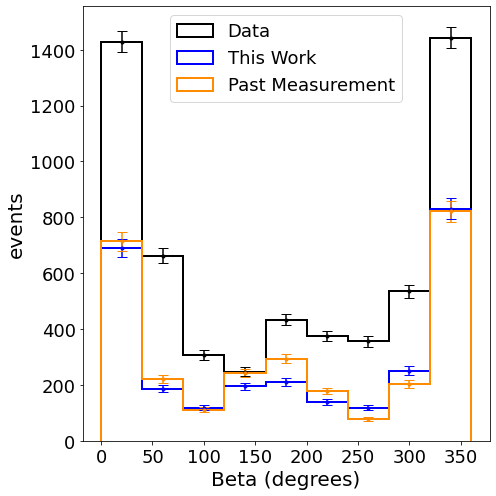

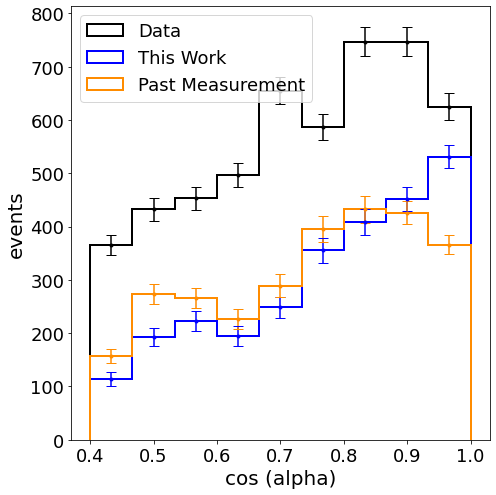

In [12]:
numofsteps=10

plt.figure(figsize=(7,7))
h=plt.hist(MuonsNoSparks['beta']*180/np.pi,bins=np.linspace(0,360,numofsteps),color='black',histtype='step',label='Data',linewidth=2)
plt.errorbar((h[1][1:]+h[1][:-1])/2,h[0],yerr=np.sqrt(h[0]),capsize=5,fmt='.',color='black')



MCwt=(MCmusSpkCut['WeightedPts']+MCmusSpkCut['WeightedPtsZat']+MCmusSpkCut['WeightedPtsEpos'])/3
ST5=np.sum(MCmusSpkCut['WeightedPts']**2)
SB5=np.sum(MCmusSpkCut['WeightedPtsZat']**2)
SE5=np.sum(MCmusSpkCut['WeightedPtsEpos']**2)


err5=((ST5+SB5+SE5)/3)**.5

Mh=plt.hist(MCmusSpkCut['beta']*180/np.pi,weights=MCmusSpkCut['WeightedPts'],bins=np.linspace(0,360,numofsteps),color='Blue',label='This Work',histtype='step',linewidth=2)
wee=np.sqrt(np.histogram(MCmusSpkCut['beta']*180/np.pi,bins=np.linspace(0,360,numofsteps), weights=MCmusSpkCut['WeightedPts']**2)[0])
plt.errorbar((Mh[1][1:]+Mh[1][:-1])/2,Mh[0],yerr=wee,fmt='.',color='Blue',capsize=5)



Polh=plt.hist(MCmusSpkCut['beta']*180/np.pi,weights=MCmusSpkCut['WeightedPts_MeasFlux'],bins=np.linspace(0,360,numofsteps),color='darkorange',label='Past Measurement',histtype='step',linewidth=2)
wee=np.sqrt(np.histogram(MCmusSpkCut['beta']*180/np.pi,bins=np.linspace(0,360,numofsteps), weights=MCmusSpkCut['WeightedPts_MeasFlux']**2)[0])
plt.errorbar((Polh[1][1:]+Polh[1][:-1])/2,Polh[0],yerr=wee,fmt='.',color='darkorange',capsize=5)

#plt.title("MC")
plt.yticks(fontsize=18)  
plt.xticks(fontsize=18) 
#plt.xlim(0,360)  
plt.ylabel('events',fontsize=20)
plt.xlabel('Beta (degrees)',fontsize=20)
plt.tight_layout()
plt.legend(fontsize=18,loc="upper center")
#plt.savefig('/Users/rogerslc/Documents/betahist.png',dpi=250,bbox_inches='tight')
plt.show()




plt.figure(figsize=(7,7))
h=plt.hist(np.cos(MuonsNoSparks['alpha']),bins=np.linspace(.4,1,numofsteps),histtype='step',color='black',label='Data',linewidth=2)
plt.errorbar((h[1][1:]+h[1][:-1])/2,h[0],yerr=np.sqrt(h[0]),capsize=5,fmt='.',color='black')


Mh=plt.hist(np.cos(MCmusSpkCut['alpha']),weights=MCmusSpkCut['WeightedPts'],bins=np.linspace(.4,1,numofsteps),color='Blue',label='This Work',histtype='step',linewidth=2)
wee=np.sqrt(np.histogram(np.cos(MCmusSpkCut['alpha']),bins=np.linspace(.4,1,numofsteps), weights=MCmusSpkCut['WeightedPts']**2)[0])
plt.errorbar((Mh[1][1:]+Mh[1][:-1])/2,Mh[0],yerr=wee,fmt='.',color='Blue',capsize=5)



Polh=plt.hist(np.cos(MCmusSpkCut['alpha']),weights=MCmusSpkCut['WeightedPts_MeasFlux'],bins=np.linspace(.4,1,numofsteps),color='darkorange',label='Past Measurement',histtype='step',linewidth=2)
wee=np.sqrt(np.histogram(np.cos(MCmusSpkCut['alpha']),bins=np.linspace(.4,1,numofsteps), weights=MCmusSpkCut['WeightedPts_MeasFlux']**2)[0])
plt.errorbar((Polh[1][1:]+Polh[1][:-1])/2,Polh[0],yerr=wee,fmt='.',color='darkorange',capsize=5)



#plt.title("MC")
plt.yticks(fontsize=18)  
plt.xticks(fontsize=18) 
#plt.xlim(0,360)  
plt.ylabel('events',fontsize=20)
plt.xlabel('cos (alpha)',fontsize=20)
plt.tight_layout()
plt.legend(fontsize=18,loc="upper left")
#plt.savefig('/Users/rogerslc/Documents/alphahist.png',dpi=250,bbox_inches='tight')
plt.show()

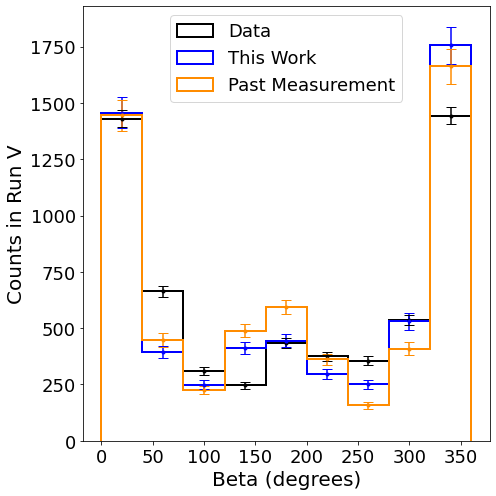

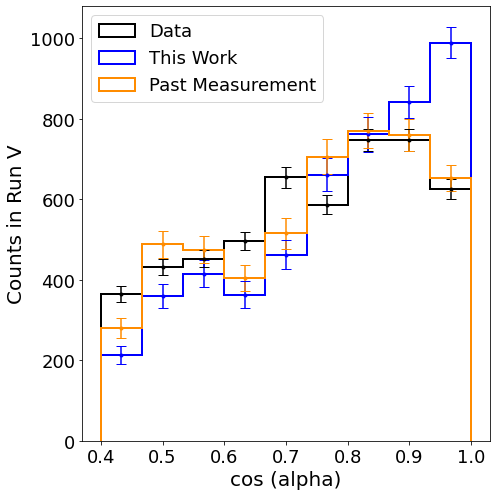

In [13]:
numofsteps=10

plt.figure(figsize=(7,7))
h=plt.hist(MuonsNoSparks['beta']*180/np.pi,bins=np.linspace(0,360,numofsteps),color='black',histtype='step',label='Data',linewidth=2)
plt.errorbar((h[1][1:]+h[1][:-1])/2,h[0],yerr=np.sqrt(h[0]),capsize=5,fmt='.',color='black')



MCwt=(MCmusSpkCut['WeightedPts']+MCmusSpkCut['WeightedPtsZat']+MCmusSpkCut['WeightedPtsEpos'])/3
ST5=np.sum(MCmusSpkCut['WeightedPts']**2)
SB5=np.sum(MCmusSpkCut['WeightedPtsZat']**2)
SE5=np.sum(MCmusSpkCut['WeightedPtsEpos']**2)


err5=((ST5+SB5+SE5)/3)**.5

Mh=plt.hist(MCmusSpkCut['beta']*180/np.pi,weights=MCmusSpkCut['WeightedPts']*h[0].sum()/MCmusSpkCut['WeightedPts'].sum(),bins=np.linspace(0,360,numofsteps),color='Blue',label='This Work',histtype='step',linewidth=2)
wee=np.sqrt(np.histogram(MCmusSpkCut['beta']*180/np.pi,bins=np.linspace(0,360,numofsteps), weights=(MCmusSpkCut['WeightedPts']*h[0].sum()/MCmusSpkCut['WeightedPts'].sum())**2)[0])
plt.errorbar((Mh[1][1:]+Mh[1][:-1])/2,Mh[0],yerr=wee,fmt='.',color='Blue',capsize=5)



Polh=plt.hist(MCmusSpkCut['beta']*180/np.pi,weights=MCmusSpkCut['WeightedPts_MeasFlux']*h[0].sum()/MCmusSpkCut['WeightedPts_MeasFlux'].sum(),bins=np.linspace(0,360,numofsteps),color='darkorange',label='Past Measurement',histtype='step',linewidth=2)
wee=np.sqrt(np.histogram(MCmusSpkCut['beta']*180/np.pi,bins=np.linspace(0,360,numofsteps), weights=(MCmusSpkCut['WeightedPts_MeasFlux']*h[0].sum()/MCmusSpkCut['WeightedPts_MeasFlux'].sum())**2)[0])
plt.errorbar((Polh[1][1:]+Polh[1][:-1])/2,Polh[0],yerr=wee,fmt='.',color='darkorange',capsize=5)

#plt.title("MC")
plt.yticks(fontsize=18)  
plt.xticks(fontsize=18) 
#plt.xlim(0,360)  
plt.ylabel('Counts in Run V',fontsize=20)
plt.xlabel('Beta (degrees)',fontsize=20)
plt.tight_layout()
#plt.legend(fontsize=18,loc="upper center", ncol=3, title="Mass Fraction of $^{3}$He",title_fontsize=18)
plt.legend(fontsize=18,loc="upper center")
#plt.savefig('/Users/rogerslc/Documents/betahist.png',dpi=250,bbox_inches='tight')
plt.show()




plt.figure(figsize=(7,7))
h=plt.hist(np.cos(MuonsNoSparks['alpha']),bins=np.linspace(.4,1,numofsteps),histtype='step',color='black',label='Data',linewidth=2)
plt.errorbar((h[1][1:]+h[1][:-1])/2,h[0],yerr=np.sqrt(h[0]),capsize=5,fmt='.',color='black')


Mh=plt.hist(np.cos(MCmusSpkCut['alpha']),weights=MCmusSpkCut['WeightedPts']*h[0].sum()/MCmusSpkCut['WeightedPts'].sum(),bins=np.linspace(.4,1,numofsteps),color='Blue',label='This Work',histtype='step',linewidth=2)
wee=np.sqrt(np.histogram(np.cos(MCmusSpkCut['alpha']),bins=np.linspace(.4,1,numofsteps), weights=(MCmusSpkCut['WeightedPts']*h[0].sum()/MCmusSpkCut['WeightedPts_MeasFlux'].sum())**2)[0])
plt.errorbar((Mh[1][1:]+Mh[1][:-1])/2,Mh[0],yerr=wee,fmt='.',color='Blue',capsize=5)


Polh=plt.hist(np.cos(MCmusSpkCut['alpha']),weights=MCmusSpkCut['WeightedPts_MeasFlux']*h[0].sum()/MCmusSpkCut['WeightedPts_MeasFlux'].sum(),bins=np.linspace(.4,1,numofsteps),color='darkorange',label='Past Measurement',histtype='step',linewidth=2)
wee=np.sqrt(np.histogram(np.cos(MCmusSpkCut['alpha']),bins=np.linspace(.4,1,numofsteps), weights=(MCmusSpkCut['WeightedPts_MeasFlux']*h[0].sum()/MCmusSpkCut['WeightedPts_MeasFlux'].sum())**2)[0])
plt.errorbar((Polh[1][1:]+Polh[1][:-1])/2,Polh[0],yerr=wee,fmt='.',color='darkorange',capsize=5)



plt.yticks(fontsize=18)  
plt.xticks(fontsize=18) 
#plt.xlim(0,360)  
plt.ylabel('Counts in Run V',fontsize=20)
plt.xlabel('cos (alpha)',fontsize=20)
plt.tight_layout()
plt.legend(fontsize=18,loc="upper left")
#plt.savefig('/Users/rogerslc/Documents/alphahist.png',dpi=250,bbox_inches='tight')
plt.show()

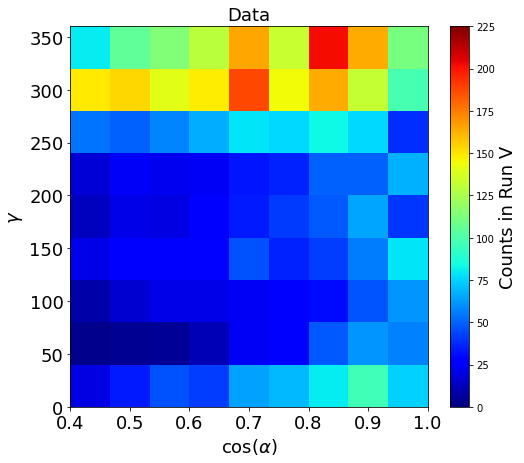

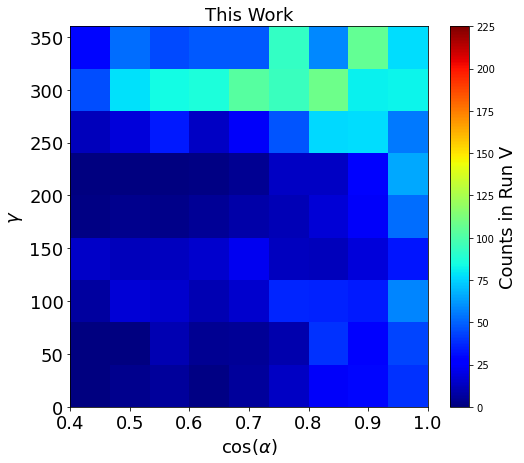

In [14]:
vmn=0
vmx=225
plt.figure(figsize=(8,7))
h2d=plt.hist2d( np.cos(MuonsNoSparks['alpha']),MuonsNoSparks['gamma'],bins=[np.linspace(.4,1,numofsteps),np.linspace(0,360,numofsteps)], cmap=plt.cm.jet,vmin=vmn,vmax=vmx)

plt.yticks(fontsize=18)  
plt.xticks(fontsize=18) 
plt.ylabel(r'$\gamma$',fontsize=18)
plt.xlabel(r'cos($\alpha$)',fontsize=18)
plt.title('Data',fontsize=18)
cbar=plt.colorbar()
cbar.set_label('Counts in Run V',fontsize=18)
#plt.savefig('/Users/rogerslc/Documents/DataFlux2d.png',dpi=250,bbox_inches='tight')
plt.show()


plt.figure(figsize=(8,7))
MCh2d=plt.hist2d( np.cos(MCmusSpkCut['alpha']),MCmusSpkCut['gamma'],weights=MCwt,bins=[np.linspace(.4,1,numofsteps),np.linspace(0,360,numofsteps)], cmap=plt.cm.jet,vmin=vmn,vmax=vmx)
plt.yticks(fontsize=18)  
plt.xticks(fontsize=18) 
plt.ylabel(r'$\gamma$',fontsize=18)
plt.xlabel(r'cos($\alpha$)',fontsize=18)
plt.title('This Work',fontsize=18)
cbar=plt.colorbar()
cbar.set_label('Counts in Run V',fontsize=18)
#plt.savefig('/Users/rogerslc/Documents/MCFlux2d.png',dpi=250,bbox_inches='tight')
plt.show()

2225.088743722507 2741.8088229451764 2796.530716911301 2861.5472182066364 5108.0 2.295638775941345


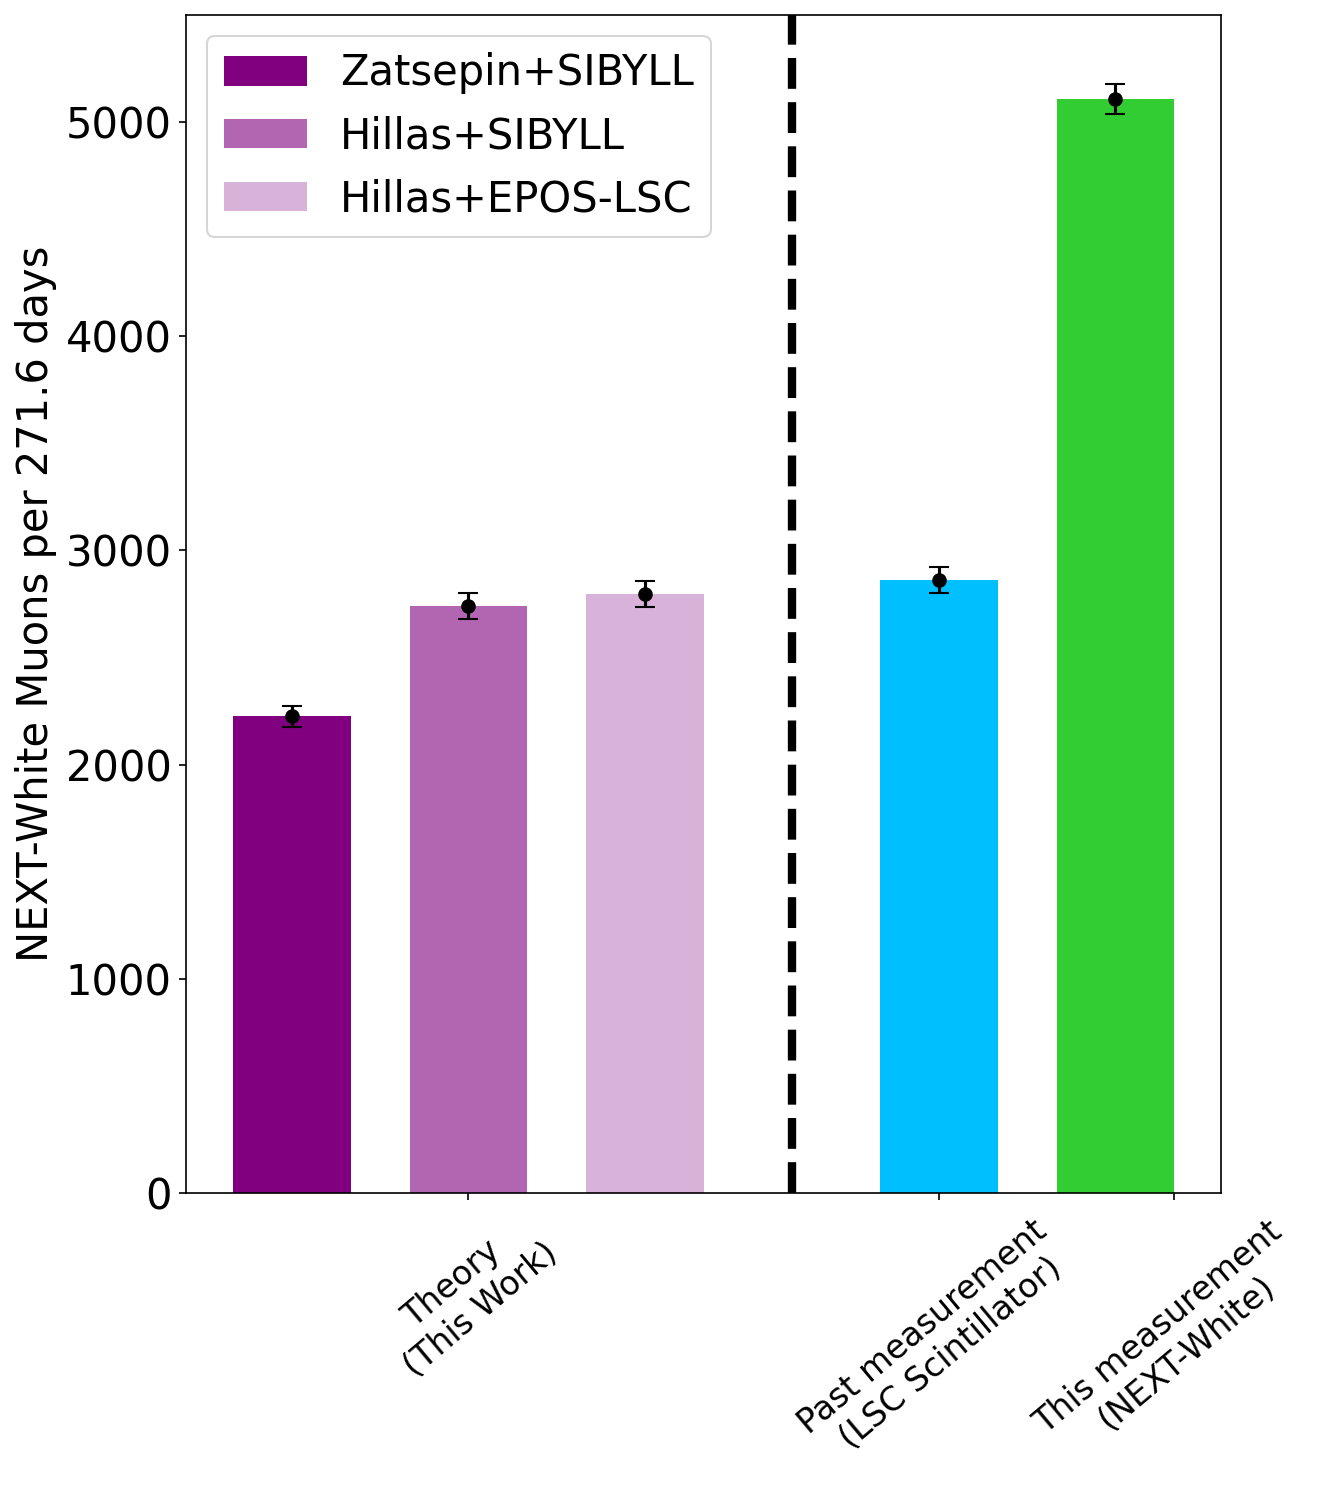

In [15]:
WT1=5.26*(271.6*24*60*60)*(.178*.47) #from paper
err1=.21

WT2=4.77 *(271.6*24*60*60)*(.178*.47) #from Pau
err2=.05




xplace=[1.6,2.2,2.8,3.8,4.4]

Xlableslist=["Theory \n(This Work)", "Past measurement \n(LSC Scintillator)", "This measurement \n(NEXT-White)"]
xplacelist=[2.2,3.8,4.6]



MCwt=MCmusSpkCut['WeightedPts']
MCzt=MCmusSpkCut['WeightedPtsZat']
MCep=MCmusSpkCut['WeightedPtsEpos']
CnMeas=MCmusSpkCut['WeightedPts_MeasFlux']


WT3=np.sum(MCzt)
err3=np.sum(MCzt**2)**.5

WT4=np.sum(MCwt)
err4=np.sum(MCwt**2)**.5

WT5=np.sum(CnMeas)
err5=np.sum(CnMeas**2)**.5


WT6=np.sum(h2d[0])
err6=np.sum(h2d[0])**.5

WT7=np.sum(MCep)
err7=np.sum(MCep**2)**.5


fig = plt.figure(figsize=(9,10),dpi=150)
ax1 = fig.add_subplot(111)
#ax1.bar(xplace[0],height=WT1, width=.4,color="deepskyblue")
#ax1.bar(xplace[1],height=WT2, width=.4,color="deepskyblue")
ax1.bar(xplace[0],height=WT3, width=.4,color="purple",label='Zatsepin+SIBYLL',alpha=1)
plt.errorbar(xplace[0],WT3,color='k',yerr=err3, fmt="o",capsize=5)

ax1.bar(xplace[1],height=WT4, width=.4,color="purple",label='Hillas+SIBYLL',alpha=0.6)
plt.errorbar(xplace[1],WT4,color='k',yerr=err4, fmt="o",capsize=5)

ax1.bar(xplace[2],height=WT7, width=.4,color="purple",label='Hillas+EPOS-LSC',alpha=0.3)
plt.errorbar(xplace[2],WT7,color='k',yerr=err4, fmt="o",capsize=5)

ax1.bar(xplace[3],height=WT5, width=.4,color="deepskyblue")
plt.errorbar(xplace[3],WT5,color='k',yerr=err5, fmt="o",capsize=5)

ax1.bar(xplace[4],height=WT6, width=.4,color="limegreen")
plt.errorbar(xplace[4],WT6,color='k',yerr=err6, fmt="o",capsize=5)

ax1.set_ylabel('NEXT-White Muons per 271.6 days',fontsize=20)
#ax1.text(xplacelist[0:3],Xlableslist[0:3],rotation='verticle')

#plt.errorbar(xplace[0],WT1,color='k',yerr=err1, fmt="o",capsize=5,label='Canfranc Mu Meas')
#plt.errorbar(xplace[1],WT2,color='k',yerr=err2, fmt="o",capsize=5,label='Current Muon Flux Meas from Next')
#plt.errorbar(xplace[2],WT3,color='k',yerr=err3, fmt="o",capsize=5,label='this work')

plt.plot([3.3,3.3],[0,5500],'--',linewidth=4,color='black')
plt.ylim(0,5500)

plt.yticks(fontsize=20)
plt.xticks(xplacelist,Xlableslist,fontsize=16,rotation=40)
plt.tight_layout()
plt.legend(fontsize=20)

plt.yticks(fontsize=20) 
#plt.semilogy()
#plt.tight_layout()

#plt.savefig("/Users/rogerslc/Documents/diffflux.png",dpi=250,bbox_inches='tight')

print(WT3,WT4,WT7,WT5,WT6,WT6/WT3)

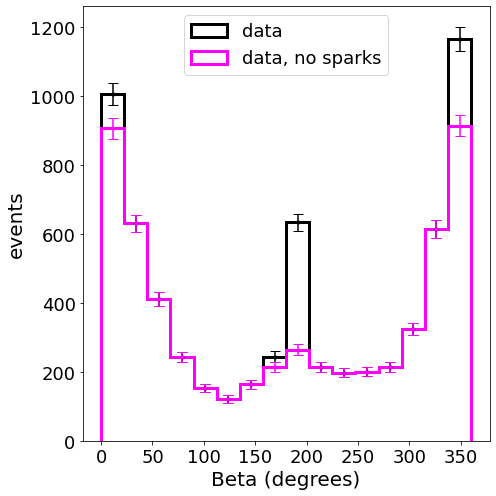

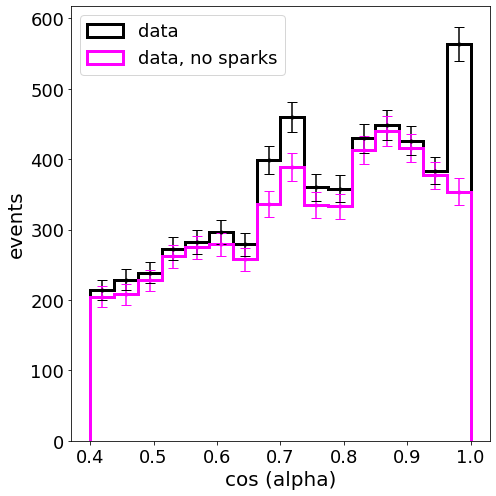

In [16]:
#spark cuts
numofsteps=17
plt.figure(figsize=(7,7))
h=plt.hist(np.rad2deg(MuonsFromData['beta']),bins=np.linspace(0,360,numofsteps),color='black',histtype='step',label='data',linewidth=3)
plt.errorbar((h[1][1:]+h[1][:-1])/2,h[0],yerr=np.sqrt(h[0]),capsize=5,fmt='.',color='black')
h4=plt.hist(np.rad2deg(MuonsFromData[(MuonsFromData.zvariance>4)&(np.abs(MuonsFromData.beta-330)>4)]['beta']),bins=np.linspace(0,360,numofsteps),color='magenta',histtype='step',label='data, no sparks',linewidth=3)
plt.errorbar((h4[1][1:]+h4[1][:-1])/2,h4[0],yerr=np.sqrt(h4[0]),capsize=5,fmt='.',color='magenta')
plt.yticks(fontsize=18)  
plt.xticks(fontsize=18) 
 
plt.ylabel('events',fontsize=20)
plt.xlabel('Beta (degrees)',fontsize=20)
plt.tight_layout()
plt.legend(fontsize=18,loc="upper center")
#plt.savefig('/Users/rogerslc/Documents/betasparks.png',dpi=250,bbox_inches='tight')
plt.show()

plt.figure(figsize=(7,7))
h=plt.hist(np.cos(MuonsFromData['alpha']),bins=np.linspace(.4,1,numofsteps),histtype='step',color='black',label='data',linewidth=3)
plt.errorbar((h[1][1:]+h[1][:-1])/2,h[0],yerr=np.sqrt(h[0]),capsize=5,fmt='.',color='black')
h4=plt.hist(np.cos(MuonsFromData[(MuonsFromData.zvariance>4)&(np.abs(MuonsFromData.beta-330)>4)]['alpha']),bins=np.linspace(.4,1,numofsteps),color='magenta',histtype='step',label='data, no sparks',linewidth=3)
plt.errorbar((h4[1][1:]+h4[1][:-1])/2,h4[0],yerr=np.sqrt(h4[0]),capsize=5,fmt='.',color='magenta')
#plt.title("MC")
plt.yticks(fontsize=18)  
plt.xticks(fontsize=18) 
#plt.xlim(0,360)  
plt.ylabel('events',fontsize=20)
plt.xlabel('cos (alpha)',fontsize=20)
plt.tight_layout()
plt.legend(fontsize=18,loc="upper left")
#plt.savefig('/Users/rogerslc/Documents/alphasparks.png',dpi=250,bbox_inches='tight')
plt.show()

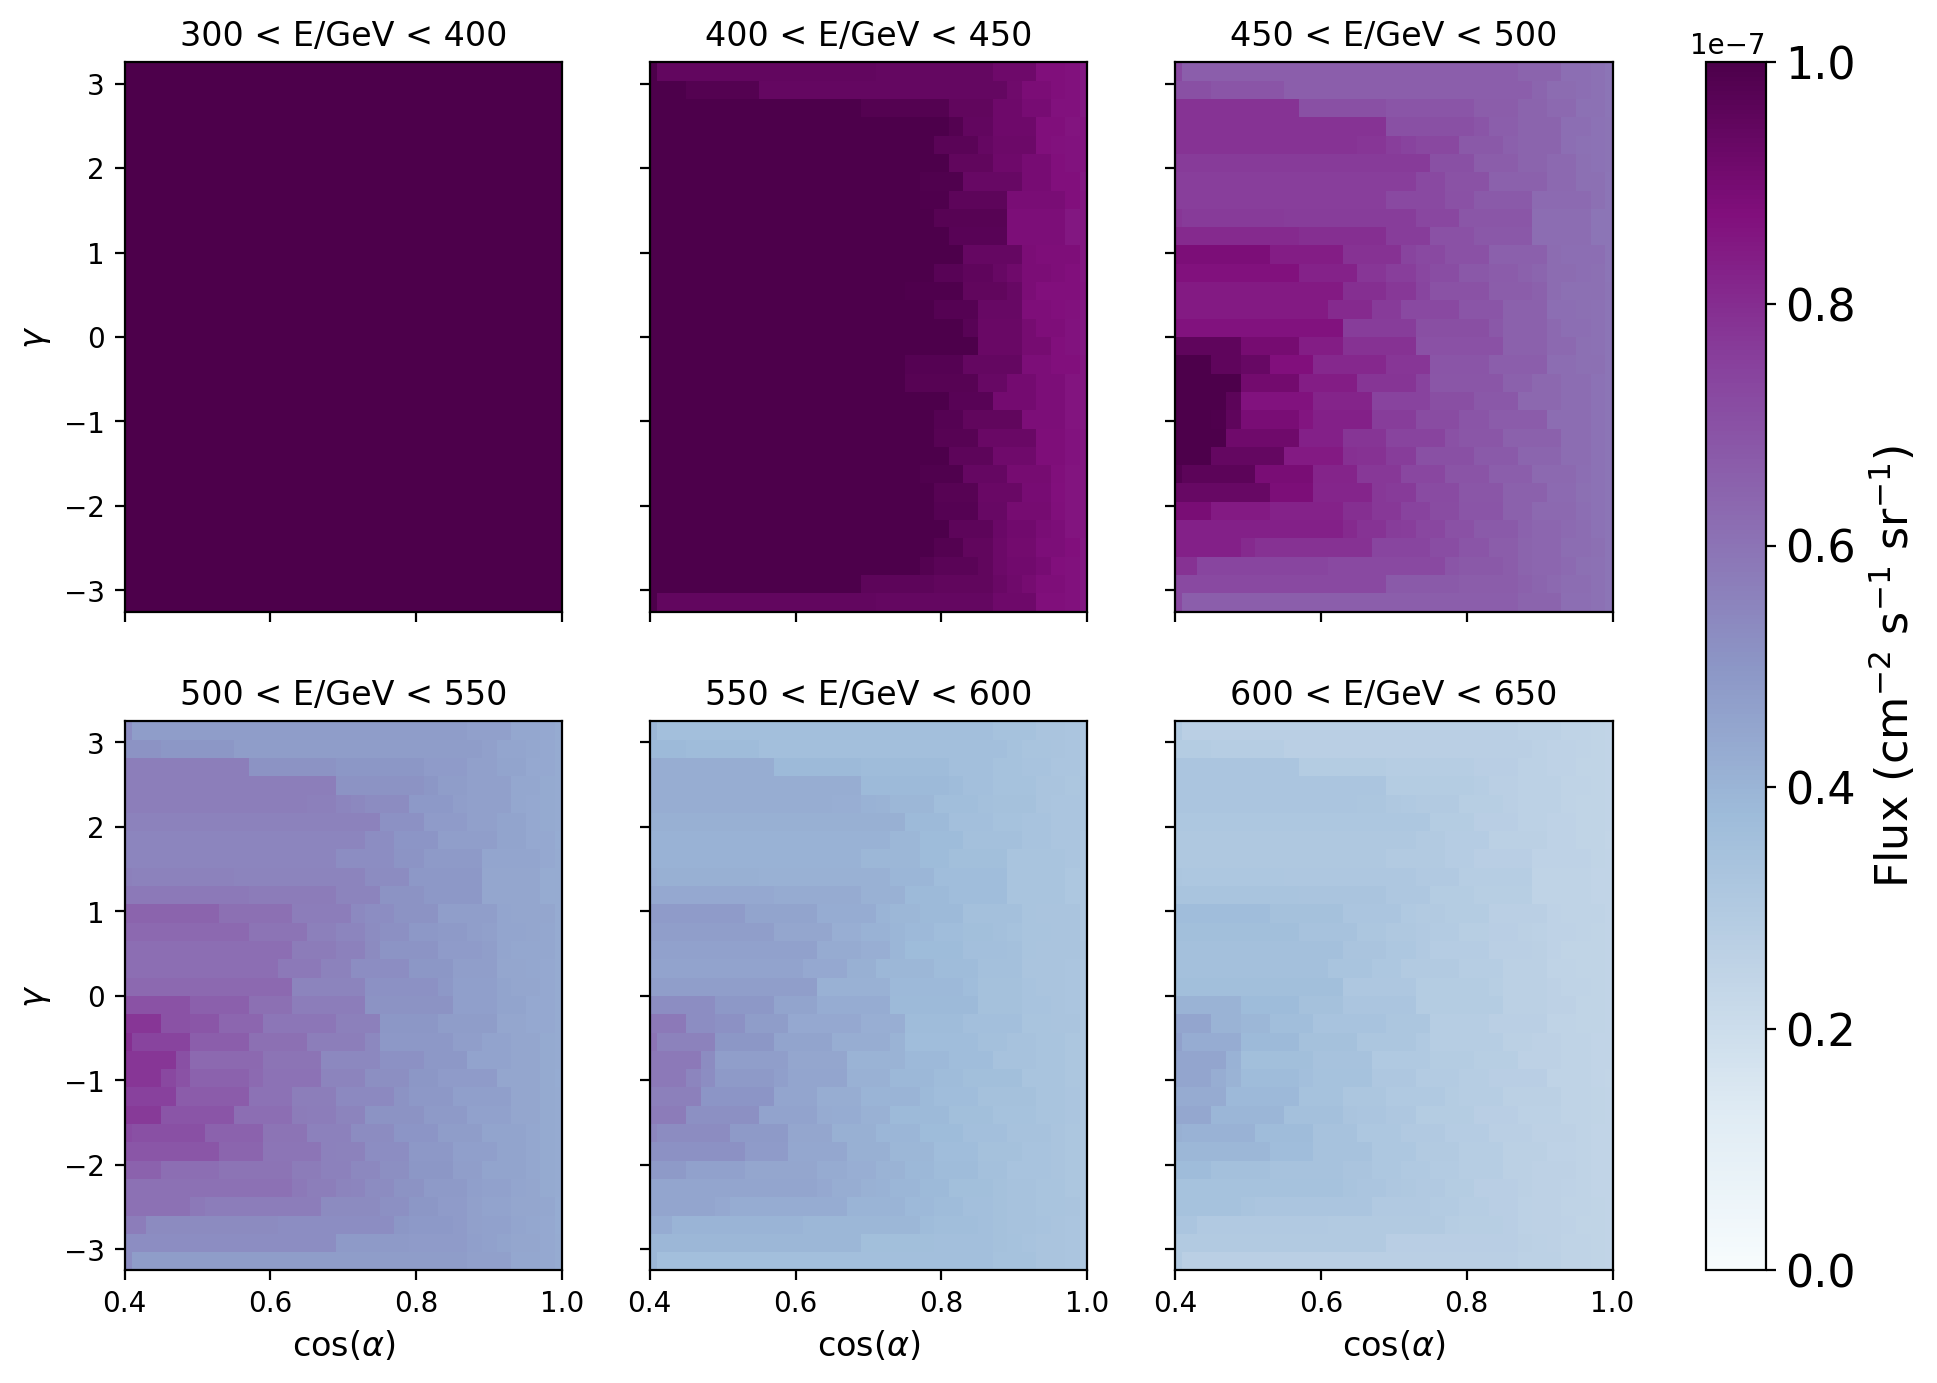

In [17]:
startn=1
fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(12,8),dpi=200, sharex=True, sharey=True)
for iax in range(0,len(axes.flat)):
    ax=axes.flatten()[iax]
    im=ax.pcolormesh(cosas,gs,np.transpose(FluxMeshes[iax+startn]),cmap='BuPu',shading='auto',vmin=0,vmax=1e-7)
    ax.set_title(str(EBins[iax+startn])+ " < E/GeV < " + str(EBins[iax+startn+1]))
    ax.set_xlim(0.4,1)
cbar=fig.colorbar(im, ax=axes.ravel().tolist(),label='Flux (cm$^{-2}$ s$^{-1}$ sr$^{-1}$)')
cbar.set_label('Flux (cm$^{-2}$ s$^{-1}$ sr$^{-1}$)',fontsize=16)
cbar.ax.tick_params(labelsize=16)

axes[1,0].set_xlabel(r"cos($\alpha$)",fontsize=12)
axes[1,1].set_xlabel(r"cos($\alpha$)",fontsize=12)
axes[1,2].set_xlabel(r"cos($\alpha$)",fontsize=12)

axes[1,0].set_ylabel(r"$\gamma$",fontsize=12)
axes[0,0].set_ylabel(r"$\gamma$",fontsize=12)

#plt.savefig('/Users/rogerslc/Documents/MuFluxPred/MCeqFluxes.png',dpi=250,bbox_inches='tight')
plt.show()

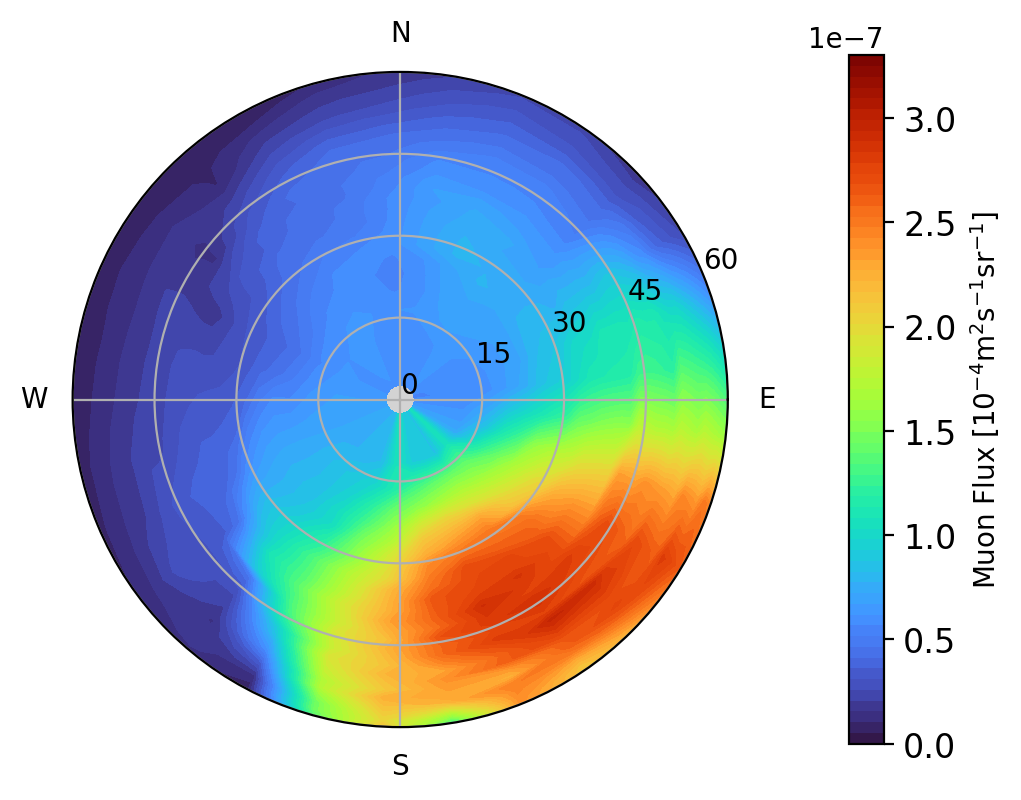

In [18]:
fig, ax = plt.subplots(subplot_kw=dict(projection='polar'),constrained_layout=True,figsize=(5,5),dpi=200)
levels=np.linspace(0,3.3e-7,65)
im=ax.contourf(gs,np.arccos(cosas-0.001)*180/3.14, totalflux,cmap='turbo',levels=levels)
ax.set_rlim(0,60)
ax.set_rticks([0,15,30,45,60])
#ax.tick_params(axis='both', colors='White')
cb =plt.colorbar(im, shrink=0.7,ticks=np.arange(0,3.5e-7,5e-8))
#cb = fig.colorbar(im, shrink=0.7)

cb.set_label("Muon Flux [10$^{-4}$m$^{2}$s$^{-1}$sr$^{-1}$]")
cb.ax.tick_params(labelsize=12)
ax.set_thetagrids([0,90,180,270],['E','N','W','S'])
ax.set(facecolor = "lightgrey",alpha=0.2)
#plt.savefig("/Users/rogerslc/Documents/MuFluxPred/PolarFluxes.png",dpi=250,bbox_inches='tight')
plt.show()

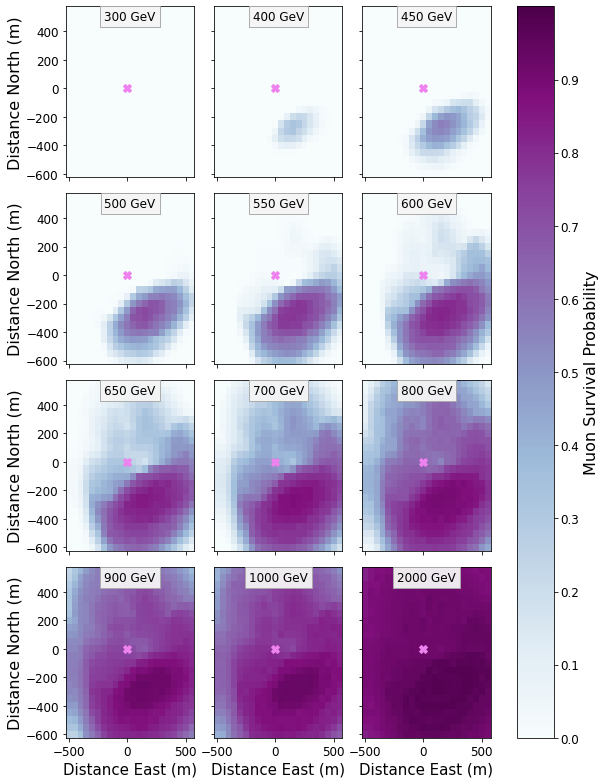

In [19]:
a=0

locs=[1,2,3,4,5,6,7,8,9,10,11,12]

energies=[250,500,750,1000,1500,4000,10000]
energies=[100,300,400,450,500,550,600,650,700,800,900,1000,2000,4000,6000]


spacing=50
NumToRun=1000
Xmin=-500-spacing
Xmax=1500+spacing/2
Ymin=-2255-spacing
Ymax=745+spacing/2

fig, axes = plt.subplots(nrows=4, ncols=3,figsize=(8.5,11), sharex=True, sharey=True)
cmap = plt.get_cmap('BuPu')
for ax in axes.flat:
    LOC=locs[a]
    


    NRG=energies[LOC]

    with open('/Users/rogerslc/PROPOSAL/InterpFunctions/Proposal_Muons_interpolator'+str(NRG)+'GeV.pkl', 'rb') as f:
        PercentMuons = pickle.load(f)

    intexs=[]
    inteys=[]
    intepercs=[]
    for X in range(-500,600,spacing):
        for Y in range(-600,600,spacing):
            intexs.append(X)
            inteys.append(Y)
            intepercs.append(PercentMuons(X,Y))


    intepercs = np.array(intepercs)
    intepercs=intepercs.reshape(len(np.unique(intexs)), len(np.unique(inteys)))
            
    
    im=ax.pcolormesh(np.unique(intexs),np.unique(inteys),np.transpose(intepercs),cmap=cmap,shading='auto',vmin=0, vmax=1)
    #ax.set_ylim(Ymin,Ymax)
    #ax.set_xlim(Xmin,Xmax)
    ax.tick_params(axis='both', which='major', labelsize=12)


    #ax.title("Energy ="+str(energies[LOC]*GeV/10**6)+"TeV")
    ax.plot([0],[0],'X',label='Location of LSC',color='violet',markersize=8)
    
    ax.set_title(str(NRG)+' GeV', y=1, pad=-14,bbox=dict(facecolor='whitesmoke',alpha=.95, edgecolor='darkgray'))
    #ax.legend(loc='upper center',title=str(NRG)+'GeV',title_fontsize=12)

    if (LOC>9):
        ax.set_xlabel("Distance East (m)", fontsize=15)
    if ((LOC+2)%3==0):        
        ax.set_ylabel("Distance North (m)", fontsize=16)
    a+=1
fig.subplots_adjust(wspace=.05, hspace=.05)
fig.tight_layout()
cbar=fig.colorbar(im, ax=axes.ravel().tolist())
cbar.set_ticks(np.arange(0, 1, 0.1))
cbar.set_label('Muon Survival Probability', fontsize=16)
cbar.ax.tick_params(labelsize=12)
#fig.clim(0,1)


#fig.savefig("/Users/rogerslc/PROPOSAL/PROPOSAL/SimulatedPercents.png",dpi=250,bbox_inches='tight')

#plt.show()